In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE

## 1. Преобразование признаков

In [4]:
data = pd.read_csv('../datasets/travel_insurance.csv')

## Прямое кодирование (OHE)
data_ohe = pd.get_dummies(data, dtype=int, dummy_na=True, drop_first=True)

## Разделение на выборки
features_train, features_valid, target_train, target_valid = train_test_split(
    data_ohe.drop('Claim', axis=1), 
    data_ohe['Claim'], 
    random_state=12345
)

## Стандартизация численных признаков
numeric = ['Duration', 'Net Sales', 'Commission (in value)', 'Age']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_train;

## 2. Метрики классификации

In [8]:
data = pd.read_csv('../datasets/travel_insurance_preprocessed.csv')
target = data['Claim']
features = data.drop('Claim', axis=1)
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)

model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
probablities_one_valid = model.predict_proba(features_valid)[:, 1]
roc_auc_score(target_valid, probablities_one_valid)

0.8222702270643766

### ROC-кривая

Text(0.5, 1.0, 'ROC-кривая')

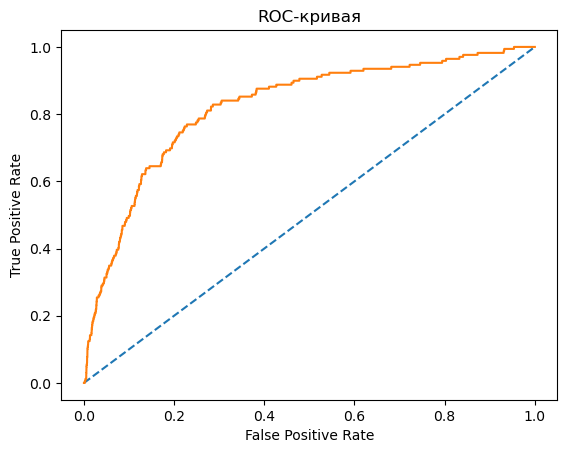

In [23]:
tpr, fpr, threshold = roc_curve(target_valid, probablities_one_valid)
plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(tpr, fpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

### PR-кривая 

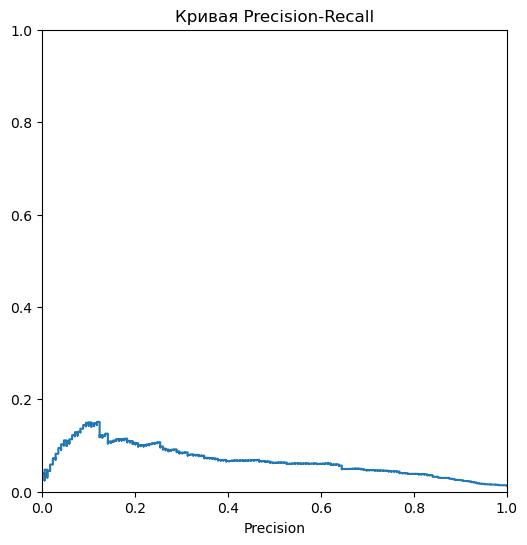

In [25]:
precision, recall, thresholds = precision_recall_curve(target_valid, probablities_one_valid)
plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Precision')
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.title('Кривая Precision-Recall')
plt.show()

### Изменение порога

In [27]:
for threshold in np.arange(0, 0.3, 0.02):
    predicted_valid = probablities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, f1-мера = {:.3f}".format(
        threshold, precision, recall, f1))

Порог = 0.00 | Точность = 0.013, Полнота = 1.000, f1-мера = 0.026
Порог = 0.02 | Точность = 0.052, Полнота = 0.645, f1-мера = 0.096
Порог = 0.04 | Точность = 0.061, Полнота = 0.609, f1-мера = 0.110
Порог = 0.06 | Точность = 0.072, Полнота = 0.367, f1-мера = 0.120
Порог = 0.08 | Точность = 0.097, Полнота = 0.254, f1-мера = 0.140
Порог = 0.10 | Точность = 0.112, Полнота = 0.178, f1-мера = 0.137
Порог = 0.12 | Точность = 0.146, Полнота = 0.107, f1-мера = 0.123
Порог = 0.14 | Точность = 0.033, Полнота = 0.012, f1-мера = 0.017
Порог = 0.16 | Точность = 0.036, Полнота = 0.006, f1-мера = 0.010
Порог = 0.18 | Точность = 0.000, Полнота = 0.000, f1-мера = 0.000
Порог = 0.20 | Точность = 0.000, Полнота = 0.000, f1-мера = 0.000
Порог = 0.22 | Точность = 0.000, Полнота = 0.000, f1-мера = 0.000
Порог = 0.24 | Точность = 0.000, Полнота = 0.000, f1-мера = 0.000
Порог = 0.26 | Точность = 0.000, Полнота = 0.000, f1-мера = 0.000
Порог = 0.28 | Точность = 0.000, Полнота = 0.000, f1-мера = 0.000


### Upsampling

In [29]:
def upsample(features_train, target_train, repeat):
    features_zero = features_train[target_train==0]
    features_one = features_train[target_train==1]
    target_zero = target_train[target_train==0]
    target_one = target_train[target_train==1]
    features_upsampled = pd.concat([features_zero] + [features_one] * repeat)
    target_upsampled = pd.concat([target_zero] + [target_one] * repeat)
    return shuffle(features_upsampled, target_upsampled, random_state=12345)

In [72]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 10)

model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
f1_score(target_valid, predicted_valid)
roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1])

0.8104425368780732

## Smote

In [84]:
smote = SMOTE(random_state=12345)
features_sm, target_sm = smote.fit_resample(features_train, target_train)

model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_sm, target_sm)
predicted_valid = model.predict(features_valid)
roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1])

0.7964049087423952

### Downsampling

In [19]:
def downsample(features_train, target_train, fraction):
    features_zero = features_train[target_train==0]
    features_one = features_train[target_train==1]
    target_zero = target_train[target_train==0]
    target_one = target_train[target_train==1]
    features_upsampled = pd.concat([features_zero.sample(frac=fraction, random_state=12345), features_one])
    target_upsampled = pd.concat([target_zero.sample(frac=fraction, random_state=12345), target_one])
    return shuffle(features_upsampled, target_upsampled, random_state=12345)

In [20]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)

model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
f1_score(target_valid, predicted_valid)

0.13333333333333333